# Decoding photographs of the IBM 5100's Executable ROS

![A picture of an IBM 5100 computer on a desk. The top cover is removed and wires sprout from the system backplane, some going to a logic analyser to the right of the computer, others going to a solderless breadboard resting on top of a nearby jar of pickled jalapeño peppers. The breadboard has a row of DIP switches, a resistor pack, and wiring. To the left, a digital SLR camera rests on a tripod, pointed at the computer's tiny screen, which is showing 16 rows of hexadecimal digits. The lap and right hand of a person wearing tan trousers can be seen at bottom left; a grounding strap extends from the person's hand to a metal part of the 5100's frame. Regarding other images in this file: I'm unaware of how to add alt text to these images, but these are a few cursory visualisations of screen images and digits at various processing stages and are not at all necessary for understanding the procedure described herein.](dumpros_small.jpg)

_TL/DR? Just want to see the code? Well, go on and scroll then..._ ↓↓↓

## Objective

Use elementary image processing and machine learning techniques to decode images of a computer screen showing hexadecimal digits. The data in these images are ROM contents from an interesting old computer.

## Background

The [IBM 5100](https://en.wikipedia.org/wiki/IBM_5100) is an early personal computer (ostensibly portable at 24 kg). Depending on customer-selected options, a 5100 could have interactive programming environments for [APL](https://en.wikipedia.org/wiki/APL_programming_language) and [BASIC](https://en.wikipedia.org/wiki/BASIC) built into its ROM. Or, if you prefer, its ROS ("read-only storage"), which seems to have been the IBM-favoured term.

The 5100's design took advantage of existing hardware and software components at IBM. In particular, the APL and BASIC interpreters were not native 5100 programs---instead, they were modified versions of the interpreters IBM sold for their [System/360](https://en.wikipedia.org/wiki/IBM_System/360) mainframe and [System/3](https://en.wikipedia.org/wiki/IBM_System/3) midrange computers respectively. When a 5100 presents the APL workspace, it's actually running a (limited) System/360 emulator software that hosts the interpreter. For BASIC, an analogous situation obtains where the 5100 emulates a System/3.

The 5100's real processor is a 16-bit device called [PALM](https://en.wikipedia.org/wiki/IBM_PALM_processor), and of course this is the architecture that the emulators themselves are written for. (Trivia: PALM isn't a microprocessor but a collection of ICs and gate arrays on a few separate circuit board modules.)

The youngest 5100s are a bit over 40 at time of writing, and some accounts online suggest that the ROS devices are no longer dependable. This notebook is part of an effort to back up the entire IBM 5100 ROS to modern media. Specifically, this notebook contains code that analyses screenshots (that is, photographs taken with a camera) containing 512-byte portions of the "Executable ROS"---the ROS containing the native PALM code. 

## Data and strategy

The IBM 5100's processor cannot address its Executable ROS code---in this sense, the 5100 is a [Harvard architecture](https://en.wikipedia.org/wiki/Harvard_architecture) machine. It's thus not possible for the 5100 to load this data into RAM (that's RWS in IBM-speak) or send it to the I/O port. This said, a moderatly-invasive recovery is possible, thanks to several propitious IBM 5100 features:

1. The 5100 has a hardware switch that causes the display to show the PALM's register contents in hexadecimal; however, on the very first instruction cycle, this display actually shows the first 512 bytes of the Executable ROS instead.

2. Inside the case, the 5100 has two special switches intended for IBM customer engineers. These switches freeze the PALM clock and allow manual stepping through code. Rebooting the 5100 with the PALM frozen causesd  the Executable ROS data to remain in the register display indefinitely.

3. The 5100 backplane feaures thousands of [wire wrap](https://en.wikipedia.org/wiki/Wire_wrap) pins, one for each module socket and ribbon cable connector line, making it easy to attach wires temporarily.

4. The address bus for the Executable ROS is active-low, so an all-zero address can be manipulated into other addresses by pulling address lines to ground.

Together, these features enable a recovery the Executable ROS data as follows. **WARNING: I provide no guarantee that the following instructions will not damage your IBM 5100; do the following at your own risk!**

With the top cover removed, place the run switch in the single-step position and start the 5100. Set the DISPLAY REGISTERS switch on the front panel to on. The screen will display the first 512 bytes of the Executable ROS. By carefully and selectively clipping 100Ω resistors between ground and the seven highest-order address bus lines, other 512-byte blocks of ROS data may be viewed.

After photographing all 128-possible blocks (ideally with a good camera on a tripod, perhaps with a shutter delay to minimise vibration), it is necessary to hand-transcribe a small subset of the "interesting" images (i.e. not all `0` or `F` digits) into accompanying text files. These will be used to help train the digit classifier.

When finished with that, you can apply image processing and machine learning techniques like those in this notebook to "read" the digits in the images. Finally, after reading is complete, the textual "screen dumps" can be converted into binary data with a script like the accompanying `5100_display_undump.py`.

**If you'd prefer not to undertake this procedure with your own 5100, you can download [here](https://drive.google.com/open?id=1q5YYjurnq5yGZfUq_Jt4KSqdqZ9yo5cY) the data used by (and results saved from) this notebook.** Be aware that the archive file at this link is 1.7GB (over 27,000 times larger than the Executable ROS). Or, to obtain the end product directly, along with a disassembly of the ROS code, visit [here](ftp://ftp.informatik.uni-stuttgart.de/pub/cm/ibm/ibm5100/).

## Usage note

This notebook assumes a particular file layout that is fairly apparent after some inspection of the code.

If using the data archive linked above, untar the files in the working directory of this notebook. A subdirectory called `executable` will be created with all of the necessary data files inside.

## Acknowledgements

The IBM 5100 Executable ROS data recovery documented here would not have been possible without:

* Christian Corti, who made me aware of the address bus manipulation strategy described above, and whose [IBM 5110 technical information website](http://computermuseum.informatik.uni-stuttgart.de/dev_en/ibm_5110/technik/en/5110.html) provided valuable background information.
* [bitsavers.org](http://www.bitsavers.org/), for its archived [IBM 5100](http://bitsavers.informatik.uni-stuttgart.de/pdf/ibm/5100/) and [IBM 5110](http://bitsavers.informatik.uni-stuttgart.de/pdf/ibm/5110/) technical documentation.

## Licensing

This notebook and any supporting programs, software libraries, and documentation distributed alongside it are released into the public domain without any warranty. See the LICENSE file for details.

## Who, where, when

Tom Stepleton, London, 2019-01-24

In [1]:
import collections
import h5py
import itertools
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import scipy as sp
import skimage
import skimage.io
import skimage.morphology
import sklearn.neighbors
import sklearn.svm

## Image loading and cropping

Note: in this early part of the notebook, I'm mainly examining the data. Many superfluous cells from this investigation have since been removed. In this section, I've determined the correct image to crop so that my screen images will contain almost entirely digits.

In [2]:
img = skimage.io.imread('executable/run1/IMG_2545.JPG')
img = skimage.color.rgb2gray(img)
img = img[550:-400, 1020:-730]
img.shape

(2698, 3722)

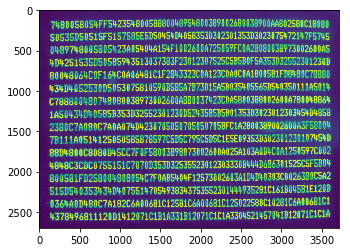

In [3]:
plt.imshow(img)

## Masking, dilation, connected components

In this section I establish a procedure for turning a 256-level greyscale image into a binary image and then identifying individual digits contained therein. Applying a [morphological operator](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.binary_dilation) that basically smears the image vertically helped rejoin digits that appeared fragmented.

The [SciPy `label` operation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html) detects contiguous `True` regions of the image, returning a new image where the pixels in each region are replaced by a region-specific unique ID number. It's intended that each region corresponds to a single digit, and in nearly all cases, they do.

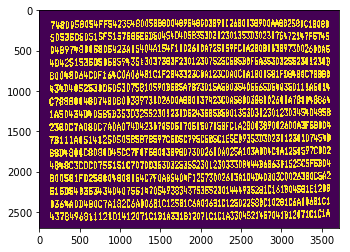

In [4]:
mask = img > (180/255)
mask = skimage.morphology.binary_dilation(mask, [[1]] * 11)
plt.imshow(mask)

In [5]:
labeled, num = sp.ndimage.label(mask)

In [6]:
num

1030

## Slicing connected components

Here I'm using [`find_objects`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.find_objects.html) to identify rectangles that fit snugly around each unique region in the image. I can use these to extract single-digit image patches like the one below. Additionally, I create a histogram of the heights and widths of these rectangles---the smaller, tiny outliers correspond to isolated specks in the image and can be discarded. For this image, it appears that the correct number of rectangles remains afterwards: 1024, for 1024 hex digits, for 512 bytes of data.

In [7]:
slices = sp.ndimage.find_objects(labeled)

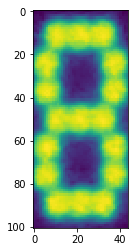

In [8]:
plt.imshow(img[slices[77]])

In [9]:
hist_rows = collections.defaultdict(lambda: 0)
hist_cols = collections.defaultdict(lambda: 0)
for rs, cs in slices:
    hist_rows[rs.stop - rs.start] += 1
    hist_cols[cs.stop - cs.start] += 1

In [10]:
hist_rows

defaultdict(<function __main__.<lambda>>,
            {11: 2,
             12: 1,
             14: 2,
             22: 1,
             98: 7,
             99: 40,
             100: 98,
             101: 194,
             102: 301,
             103: 258,
             104: 118,
             105: 7,
             108: 1})

In [11]:
hist_cols

defaultdict(<function __main__.<lambda>>,
            {1: 1,
             2: 2,
             3: 1,
             4: 1,
             16: 1,
             33: 9,
             34: 57,
             35: 85,
             36: 38,
             37: 32,
             38: 28,
             39: 19,
             40: 14,
             41: 4,
             43: 6,
             44: 65,
             45: 173,
             46: 146,
             47: 95,
             48: 61,
             49: 40,
             50: 45,
             51: 56,
             52: 38,
             53: 13})

In [12]:
sum(85 < (rs.stop-rs.start) < 110 and 28 < (cs.stop-cs.start) < 57 for rs, cs in slices)

1024

## Functions for automated digit recovery

Now that we've worked out the basics of isolating digit images from the screen photos, it's time to automate the process. These functions handle image loading, binarisation, and the collection of bounding rectangles. Besides the steps shown in earlier cells, the functions include an additional heuristic for splitting up adjacent digits that have been joined by accident, plus some manual rectangle-drawing for connecting some stubborn digit fragments.

It takes time to make image processing robust. Sometimes hacks are the fastest option.

The digit images taken from the original photos are larger than our digit classifier will need. At the bottom of this section, some experimentation to determine a practical size: 27x18, cutting the per-image pixel count by around 80%-90%.

In [13]:
def obtain_slices(mask):
    """Get array slices corresponding to hex digits in the mask image.
    
    This processing is all bespoke to our dataset of executable ROS photos.

    Args:
      mask: mask image

    Returns:
      A list of 16 lists of 64 pairs of array slices for the character image
      at the corresponding [row, col] location.
    """
    # Dimensional constraints for character image slices.
    MIN_HEIGHT = 85
    MAX_HEIGHT = 125
    MIN_WIDTH = 25
    MAX_WIDTH = 60

    slen = lambda s: s.stop - s.start  # slen: "slice len", size of slice.

    # 1. Identify all connected components in the mask image and collect slices.
    labels, num = sp.ndimage.label(mask)
    slices = sp.ndimage.find_objects(labels)
    print('Initial connected component count:', num)

    # 2. Filter out slices that are too small.
    slices = [(sr, sc) for sr, sc in slices
              if slen(sr) > MIN_HEIGHT and slen(sc) > MIN_WIDTH]
    print('After filtering out smaller components:', len(slices))

    # 3. Separate out slices that are too big.
    big_slices = [(sr, sc) for sr, sc in slices
                  if slen(sr) > MAX_HEIGHT or slen(sc) > MAX_WIDTH]
    slices = [(sr, sc) for sr, sc in slices
              if slen(sr) < MAX_HEIGHT and slen(sc) < MAX_WIDTH]
    print('Number of oversize components:', len(big_slices))

    # 4. Try to break up oversize slices.
    while big_slices:
        sr, sc = big_slices.pop()
        # Oversized vertically? No idea how that would happen. Give up.
        if slen(sr) > MAX_HEIGHT: raise RuntimeError(
            'Overly tall slice! Giving up. Slice:', sr, sc)
        # See if we can split this slice horizontally. In all likelihood,
        # an over-wide slice will be off on the right-hand side of the
        # screen where all of the letters are pressed together, so a simple
        # split down the middle will yield two halves of legal size.
        elif slen(sc) > MAX_WIDTH:
            for div in [2, 3]:
                new_width = slen(sc) // div
                if MIN_WIDTH < new_width < MAX_WIDTH:
                    slices.append(
                        (sr, slice(sc.start, sc.start + new_width)))
                    slices.append(
                        (sr, slice(sc.stop - new_width, sc.stop)))
                    break
            else:
                raise RuntimeError(
                    'Devastatingly wide slice! Giving up. Slice:', sr, sc)
        # This cut-down slice is ready to be added to the rest.
        else:
            slices.append((sr, sc))
    print('Final component count:', len(slices))
    if len(slices) != 1024: raise RuntimeError(
        '{} is not 1024. Giving up.'.format(len(slices)))

    # 5. Assemble slices into 16 rows of 64.
    # First sort by starting column. The first sixteen slices should be
    # the leftmost elements in each row. Note sort by top bounds so that
    # rows are in the proper order.
    slices.sort(key=lambda ss: ss[1].start)
    rows = [[s] for s in sorted(slices[:16], key=lambda ss: ss[0].start)]
    slices = slices[16:]

    # For all the remaining slices, take each one by one and attach it to
    # the row whose last element's top bound is closest to the new slice's
    # top bound.
    for sr, sc in slices:
        row = min(rows, key=lambda r: abs(r[-1][0].start - sr.start))
        row.append((sr, sc))

    return rows


def prepare_image_and_mask(filename):
    """Load and prepare a mask image from our dataset.
    
    The mask image shouldn't be used for recognition (although it might
    work out OK), but just for segmentation.
    
    This function recognises certain filenames and adds regions to the
    mask manually to join non-contiguous regions (*shame*).
    
    Args:
      filename: Image to load and convert to a mask image.
      
    Returns:
      A 2-D boolean array mask image.
    """
    # 1. Load and crop.
    img = skimage.io.imread(filename)
    img = skimage.color.rgb2gray(img)
    img = img[550:-400, 1020:-730]
    
    # 2. Threshold and dilate vertically to obtain the mask.
    mask = img > (180/255)
    mask = skimage.morphology.binary_dilation(mask, [[1]] * 11)
    mask = skimage.morphology.binary_closing(mask)

    # 3. Add custom patches for the images that fail to segment correctly.
    # Super sophisticated machine learning!
    if filename.endswith('_2548.JPG'):
        mask[1730:1740, 3540:3560] = True
    elif (filename.endswith('_2552.JPG') or
          filename.endswith('_2617.JPG') or
          filename.endswith('_2738.JPG')):
        mask[2210:2230, 440:455] = True
    elif (filename.endswith('_2676.JPG')):
        mask[2560:2570, 1220:1240] = True
        mask[2580:2590, 1205:1225] = True
    elif (filename.endswith('_2690.JPG') or
          filename.endswith('_2720.JPG') or
          filename.endswith('_2730.JPG') or
          filename.endswith('_2743.JPG') or
          filename.endswith('_2753.JPG')):
        mask[2550:2590, 1265:1275] = True
    elif (filename.endswith('_2713.JPG') or
          filename.endswith('_2729.JPG')):
        mask[2535:2545, 1210:1220] = True
    elif filename.endswith('_2734.JPG'):
        mask[2570:2580, 1225:1245] = True

    return img, mask

Initial connected component count: 1026
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Slices num rows: 16
Slices row lengths: {64}


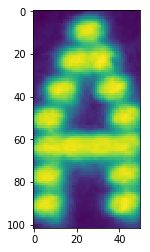

In [14]:
img, mask = prepare_image_and_mask('executable/run2/IMG_2753.JPG')
slices = obtain_slices(mask)
print('Slices num rows:', len(slices))
print('Slices row lengths:', {len(r) for r in slices})
plt.imshow(img[slices[2][5]])

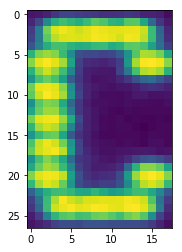

In [15]:
# Picking a canonical size for the images.
plt.imshow(
    skimage.transform.resize(
        img[slices[4][42]],
        output_shape=(27, 18),
        order=1,
        mode='reflect',
    )
)

## Extracting digit images from all files

Now we load all of the digit images from all of the image files. This can take a while...

In [16]:
# Directories with full sets of images to decode.
DIR_RUN1 = 'executable/run1'
DIR_RUN2 = 'executable/run2'

# Which subranges of the files in those directories are useful?
# In other words, these files aren't just full of $FF bytes.
GOOD_RANGES = [slice(0, 24), slice(40, 88)]

def obtain_all_digits(path):
    """Load digit images from images in a specified path.
    
    Args:
        path: Directory containing digit images.
        
    Returns:
        An ordered dict mapping filenames (sans path) to lists of 16
        lists of 64 27x18 digit images. This could use a fair amount
        of memory.
    """
    digits = collections.OrderedDict()
    
    # List JPGs, select files in "good ranges".
    filenames = [fn for fn in sorted(os.listdir(path))
                 if fn.endswith('.JPG')]
    filenames = list(itertools.chain(*[filenames[r] for r in GOOD_RANGES]))

    for filename in filenames:
        # 1. Load image, compute mask, and segment.
        print('Processing', filename)
        img, mask = prepare_image_and_mask(os.path.join(path, filename))
        slices = obtain_slices(mask)
        
        # 2. Double-check segmentation slices.
        assert len(slices) == 16
        for row in slices: assert len(row) == 64

        # 3. Collect scaled digit images.
        def get_digit(img, s):
            return skimage.transform.resize(
                img[s], output_shape=(27, 18), order=1, mode='reflect',
            ).astype(np.float32)
        digits[filename] = [
            [get_digit(img, s) for s in row] for row in slices]

    return digits


def save_digits(digits, filename):
    """Save digit images to an hdf5 file.
    
    Args:
        digits: digit image collection, as gathered by `obtain_all_images`.
        filename: name of file receiving data.
    """
    with h5py.File(filename, 'w') as f:
        for img_fn, digit_grid in digits.items():

            for i, row in enumerate(digit_grid):
                for j, digit in enumerate(row):

                    dset = f.create_dataset(
                        '{}/{}/{}'.format(img_fn, i, j),
                        data=digit,
                        compression="gzip",
                        compression_opts=9,
                    )


def load_digits(filename):
    """Load digit images from an hdf5 file.
    
    Args:
        filename: file to load.
        
    Returns:
        A digit image collection, as gathered by `obtain_all_images`.
    """
    digits = collections.OrderedDict()

    with h5py.File(filename) as f:
        for img_fn, digit_grid in f.items():
            digits[img_fn] = [[list() for _b in range(64)]
                              for _a in range(16)]
            for i, row in digit_grid.items():
                for j, digit in row.items():
                    digits[img_fn][int(i)][int(j)] = np.array(digit)
    return digits

In [17]:
digits_run1 = obtain_all_digits(DIR_RUN1)
# save_digits(digits_run1, 'executable/digits_run1.h5')
digits_run2 = obtain_all_digits(DIR_RUN2)
# save_digits(digits_run2, 'executable/digits_run2.h5')

Processing IMG_2541.JPG
Initial connected component count: 1027
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2542.JPG
Initial connected component count: 1026
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2543.JPG
Initial connected component count: 1025
After filtering out smaller components: 1023
Number of oversize components: 1
Final component count: 1024
Processing IMG_2544.JPG
Initial connected component count: 1025
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2545.JPG
Initial connected component count: 1024
After filtering out smaller components: 1023
Number of oversize components: 1
Final component count: 1024
Processing IMG_2546.JPG
Initial connected component count: 1026
After filtering out smaller components: 1024
Number of oversize components: 0
Final co

Processing IMG_2606.JPG
Initial connected component count: 1026
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2607.JPG
Initial connected component count: 1025
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2608.JPG
Initial connected component count: 1026
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2609.JPG
Initial connected component count: 1025
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2610.JPG
Initial connected component count: 1025
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2611.JPG
Initial connected component count: 1027
After filtering out smaller components: 1024
Number of oversize components: 0
Final co

Processing IMG_2711.JPG
Initial connected component count: 1027
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2712.JPG
Initial connected component count: 1027
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2713.JPG
Initial connected component count: 1026
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2714.JPG
Initial connected component count: 1025
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2715.JPG
Initial connected component count: 1025
After filtering out smaller components: 1024
Number of oversize components: 0
Final component count: 1024
Processing IMG_2716.JPG
Initial connected component count: 1028
After filtering out smaller components: 1024
Number of oversize components: 0
Final co

## Classification label I/O

And here we load the text files containing manual transcriptions of the screen images. A few things to note:

- The filenames of these files don't match the image filenames; label files and image files are paired by ordering.
- There is a text file for every image, but many are unfinished placeholders (they end in `_todo.txt`) and are ignored.
- Additionally, some images containing only `$FF` bytes are ignored.

In [18]:
# Directories with text-file sets of labels to read.
DIR_TEXT1 = 'executable/text1'
DIR_TEXT2 = 'executable/text2'  # Not used at this point.


def obtain_all_labels(path):
    """Load textual digit labels from a specified path.
    
    Label files must be text files of 16 64-character lines composed
    entirely of the characters [0123456789ABCDEF]. When listed in order,
    files ending in .txt in the path are assumed to correspond to images
    in the same ordinal position loaded from the image directories.

    Files ending in _todo.txt are assumed to contain bogus labels. Label
    grids "loaded" from these files will contain only None values.

    Args:
        path: Directory containing label text files.
    
    Returns:
        An ordered dict mapping label filenames (sans path) to 16 lists
        (rows) of 64 values (digits) that are either numbers in [0, 15]
        or None (if the filename ended in '_todo.txt').
    """
    labels = collections.OrderedDict()
    
    # List .txt files, select files in "good ranges".
    filenames = [fn for fn in sorted(os.listdir(path))
                 if fn.endswith('.txt')]
    filenames = list(itertools.chain(*[filenames[r] for r in GOOD_RANGES]))
    
    for filename in filenames:
        # 1. Don't bother loading "todo" files.
        if filename.endswith('_todo.txt'):
            labels[filename] = [[None] * 64 for _ in range(16)]
            continue
        
        # 2. Load file, validate data, and translate to numeric labels.
        with open(os.path.join(path, filename), 'r') as f:
            data = [l.upper() for l in f.read().splitlines()]
        assert len(data) == 16, (
            'Screen transcription files must be 16 lines long, but {} has {} lines.'
            ''.format(filename, len(data)))
        assert all(len(d) == 64 for d in data), (
            'All lines in screen transcription files must contain exactly 64 '
            'characters, but {} deviates from this requirement.'.format(filename))
        assert all(c in '0123456789ABCDEF' for c in ''.join(data)), (
            'Screen transcription files may only contain the characters "0123456789A'
            'BCDEF", but {} has other characters.'.format(filename))
        labels[filename] = [['0123456789ABCDEF'.find(d) for d in row]
                            for row in data]

    return labels


def save_all_labels(labels, path):
    """Save textual digit labels to a specified path.
    
    Args:
        labels: Ordered dict containing the same kind of mapping returned by
            `obtain_all_labels`.
        path: Path where these files will be saved.
    """
    for filename, label_grid in labels.items():
        with open(os.path.join(path, filename), 'w') as f:
            for row in label_grid:
                f.write(''.join('0123456789ABCDEF'[l] for l in row) + '\n')

In [19]:
labels_run1 = obtain_all_labels(DIR_TEXT1)

## Universal addressing

For a quick way to refer to individual elements in digit image and label data structures. Indexing in these structures is mostly the same, but the initial key differs. We use ordinal numbers instead in "universal keys": 3-tuples of `(index, row, column)`, and use the following helpers to access items.

In [20]:
def univ_lookup(struct, ukeys):
    """Lookup items in digit image and label data structures.
    
    This is a generator that iterates over keys and yields
    corresponding elements in `struct`.
    
    Args:
      struct: string (filename)->int (row)->int (col)->element mapping.
      ukeys: iterable of `(index, row, column)` universal key tuples.
    """
    struct_keys = list(struct.keys())
    for index, row, col in ukeys:
        yield struct[struct_keys[index]][row][col]

## Training and test data preparation

We pair labels from our more interesting text files with digit images to create datasets to train our classifier. Some data is also set aside to test the classifier after training, giving a glimpse of how it will handle digit images it hasn't seen before.

In [21]:
# Scan through all of the training labels and assemble 16 lists of 
# all of the universal keys corresponding to each label.
label_to_ukeys = [list() for _ in range(16)]
for major_index, label_grid in enumerate(labels_run1.values()):
    for i, row in enumerate(label_grid):
        for j, label in enumerate(row):
            if label is not None:
                label_to_ukeys[label].append((major_index, i, j))

for i, ukeys in enumerate(label_to_ukeys):
    print(i, ':', len(ukeys), 'examples.')

0 : 3601 examples.
1 : 1090 examples.
2 : 402 examples.
3 : 525 examples.
4 : 442 examples.
5 : 591 examples.
6 : 193 examples.
7 : 378 examples.
8 : 852 examples.
9 : 168 examples.
10 : 359 examples.
11 : 168 examples.
12 : 368 examples.
13 : 271 examples.
14 : 369 examples.
15 : 463 examples.


In [22]:
def make_train_test_data(digits, label_to_ukeys,
                         train_prop=0.85, flatten=True,
                         weighted=False):
    """Assemble training and test set data.
    
    Builds two datasets each comprising images and labels, suitable for
    supplying to `sklearn.svm.SVC.fit` and related functions.

    If `weighted` is False, each dataset is a 2-tuple whose first member
    is the input data and whose second member is the label. Both members
    will have the same number of "rows" (i.e. major index positions).
    The datasets will be balanced, which is to say that each label will
    appear the same number of times. (Therefore the least popular label
    in your dataset will determine the size of the dataset, and some of
    the data will be thrown away.)

    If `weighted` is True, each dataset is a 3-tuple, with the third tuple
    a set of weights that scale data inversely proportionally to label
    prevalence in the dataset. This is an alternative strategy to
    balancing the datasets that doesn't require discarding data.

    Args:
        digits: digit image collection, as gathered by `obtain_all_images`.
        label_to_ukeys: a 16-member list of lists of universal keys. Keys
            in the n'th list are assumed to refer to a place in the data
            where an instance of the n'th digit (in 0-9A-F) can be found.
        train_prop: What proportion of assembled data should appear in the
            training set. Remaining data will be placed in the test set.
        flatten: Whether to flatten images into vectors.
    
    Returns:
        A 4-tuple with the following elements:
        [0]: Training data, a 2- or 3-tuple suitable for use as positional
             arguments to `sklearn.svm.SVC.fit`.
        [1]: Test data, a 2- or 3-tuple suitable for use as positional
             arguments to `sklearn.svm.SVC.fit`.
        [2]: Training data universal keys.
        [3]: Test data universal keys.
        Returned data will not be in any particular order.
    """
    input_train = []
    input_test = []
    labels_train = []
    labels_test = []
    weights_train = []
    weights_test = []
    ukeys_train = []
    ukeys_test = []

    # What is the smallest number of samples for any label?
    least_samples = min(len(ukeys) for ukeys in label_to_ukeys)

    # How many sample)s are we going to take from each label?
    # None means "all of them".
    samples_per_label = None if weighted else least_samples
    if samples_per_label:
        print('Picking', samples_per_label, 'samples per label.')

    # Gather training and test data, label by label.
    for label, ukeys in enumerate(label_to_ukeys):
        sample_ukeys = random.sample(
            ukeys, samples_per_label or len(ukeys))
        weight = least_samples / len(ukeys)
        # Training data. sample_ukeys is partially depleted.
        for _ in range(int(train_prop * len(sample_ukeys))):
            ukey = sample_ukeys.pop()
            digit = next(univ_lookup(digits, [ukey]))
            input_train.append(np.ravel(digit) if flatten else digit)
            labels_train.append(label)
            weights_train.append(weight)
            ukeys_train.append(ukey)
        # Test data. Remaining sample_ukeys is scanned.
        for ukey in sample_ukeys:
            digit = next(univ_lookup(digits, [ukey]))
            input_test.append(np.ravel(digit) if flatten else digit)
            labels_test.append(label)
            weights_test.append(weight)
            ukeys_test.append(ukey)

    # Package data for returning to the caller.
    input_train = np.stack(input_train)
    input_test = np.stack(input_test)
    labels_train = np.array(labels_train)
    labels_test = np.array(labels_test)
    weights_train = np.array(weights_train)
    weights_test = np.array(weights_test)
    if weighted:
        return ((input_train, labels_train, weights_train),
                (input_test, labels_test, weights_test),
                ukeys_train, ukeys_test)
    else:
        return ((input_train, labels_train),
                (input_test, labels_test),
                ukeys_train, ukeys_test)

In [23]:
train_data, test_data, train_ukeys, test_ukeys = make_train_test_data(digits_run1, label_to_ukeys, weighted=True)
print('Train data size:', train_data[0].shape[0])
print('Test data size:', test_data[0].shape[0])

Train data size: 8696
Test data size: 1544


0


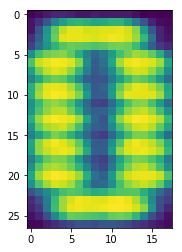

In [24]:
tmp = 1
print(train_data[1][tmp])
plt.imshow(np.copy(train_data[0][tmp]).reshape(27,18))

## Classifier training

At last we can train a classifier to recognise different digits in our images. There are many to choose from in the [scikit-learn](https://scikit-learn.org/stable/) package. A [support-vector machine](https://en.wikipedia.org/wiki/Support-vector_machine) (SVM) is a conventional, well-understood technique, and scikit-learn uses a dependable, popular implementation. It is a sensible first choice.

The maths behind SVM are complex, but in this case we can get good performance just by treating it as a black box. I've varied the `kernel` parameter to see what it would do, but all of the kernels produce the same outcome: a perfect 1.0 score on the test set data. This is encouraging. 

(Roughly, kernels are mathematical functions that can distort and/or expand the geometry of the data in hopes of making the digits easier to distinguish.)

In [25]:
def show_misclassifications(classifer, test_data, ukeys_test, labels):
    """Display misclassified data elements.
    
    Args:
      classifier: Classifier what misclassifies.
      test_data: Data that could be misclassified.
      ukeys_test: Data universal keys.
      labels: Labels datastructure.
    """
    labels_keys = list(labels.keys())
    for i in range(test_data[0].shape[0]):
        pred = classifier.predict(test_data[0][i:i+1,:])
        if pred != test_data[1][i]:
            ukey = ukeys_test[i]
            print('Classifier said', pred,
                  'but should have been {}.'.format(test_data[1][i]),
                  'At', labels_keys[ukey[0]], ukey[1]+1, ukey[2]+1)
            plt.imshow(np.copy(test_data[0][i:i+1,:]).reshape(27, 18))
            plt.show()

In [26]:
# Let's try an SVM first.

classifier = sklearn.svm.SVC()  # Default params
classifier.fit(*train_data)
print('Defaults:', classifier.score(*test_data))

for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    classifier = sklearn.svm.SVC(kernel=kernel)
    classifier.fit(*train_data)
    print(kernel, 'kernel:', classifier.score(*test_data))

Defaults: 1.0
linear kernel: 1.0
rbf kernel: 1.0
poly kernel: 1.0
sigmoid kernel: 1.0


In [27]:
# Now let's try k-nearest neighbours.
# Actually, it works pretty well too, but we'll stick with the SVM.

# classifier = sklearn.neighbors.KNeighborsClassifier()  # Default params
# classifier.fit(*train_data[:2])
# print('Defaults:', classifier.score(*test_data[:2]))

In [28]:
# Visualise any cases where the classifier misclassifies the training set
# or test set data.
show_misclassifications(classifier, train_data, train_ukeys, labels_run1)
show_misclassifications(classifier, test_data, test_ukeys, labels_run1)

## Classification

**At last!** Now that we have our classifier, we can put it to work and have it read every single digit in every single image.

In [29]:
def classify_all(classifier, digits, flatten=True):
    """Classify all digits in a digits data structure.

    Args:
        classifier: sklearn classifier.
        digits: Digits data structure, as created by `obtain_all_digits`.
        flatten: Whether to flatten images into vectors.

    Returns:
        A labels data structure, as created by `obtain_all_labels`.
    """
    labels = collections.OrderedDict()
    
    # Just label each collection of digits row-by-row.
    for img_fn, digit_grid in digits.items():
        print('Processing', img_fn)
        img_fn += '.txt'
        labels[img_fn] = []
        for row in digit_grid:
            if flatten: row = [np.ravel(d) for d in row]
            inputs = np.stack(row)
            labels[img_fn].append(list(classifier.predict(inputs)))

    return labels

In [30]:
DIR_OUT1 = 'executable/classif1'
DIR_OUT2 = 'executable/classif2'

classified_run1 = classify_all(classifier, digits_run1)
classified_run2 = classify_all(classifier, digits_run2)

save_all_labels(classified_run1, DIR_OUT1)
save_all_labels(classified_run2, DIR_OUT2)

Processing IMG_2541.JPG
Processing IMG_2542.JPG
Processing IMG_2543.JPG
Processing IMG_2544.JPG
Processing IMG_2545.JPG
Processing IMG_2546.JPG
Processing IMG_2547.JPG
Processing IMG_2548.JPG
Processing IMG_2549.JPG
Processing IMG_2550.JPG
Processing IMG_2551.JPG
Processing IMG_2552.JPG
Processing IMG_2553.JPG
Processing IMG_2554.JPG
Processing IMG_2555.JPG
Processing IMG_2556.JPG
Processing IMG_2557.JPG
Processing IMG_2558.JPG
Processing IMG_2559.JPG
Processing IMG_2560.JPG
Processing IMG_2561.JPG
Processing IMG_2562.JPG
Processing IMG_2563.JPG
Processing IMG_2564.JPG
Processing IMG_2581.JPG
Processing IMG_2582.JPG
Processing IMG_2583.JPG
Processing IMG_2584.JPG
Processing IMG_2585.JPG
Processing IMG_2586.JPG
Processing IMG_2587.JPG
Processing IMG_2588.JPG
Processing IMG_2589.JPG
Processing IMG_2590.JPG
Processing IMG_2591.JPG
Processing IMG_2592.JPG
Processing IMG_2593.JPG
Processing IMG_2594.JPG
Processing IMG_2595.JPG
Processing IMG_2596.JPG
Processing IMG_2597.JPG
Processing IMG_2

## Where to from here?

The procedure has left two (hopefully identical!) copies of the image file transcriptions in the directories `executable/classif1` and `executable/classif2`. Each transcription file has the name of the original file with the additional suffix `.txt`, e.g. `IMG_2554.JPG.txt`.

To recreate the entire contents of the original executable ROS, you'll need to add in transcription files for all the images that this procedure skipped---images that contain only `$FF` bytes. Compare your original image directory to the transcription directory, and for all image files that don't have a corresponding `.txt` file, create one with these contents:

```
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
```

The final step is to "undump" the text files into a single 64-kilobyte binary file. To do this, run the cell below, which invokes the external python program `5100_display_undump.py` on all of the transcription files in your `executable/classif1` directory, storing the output in the file `execros.bin`. It's assumed that your shell will expand the fileglob in the commandline so that the program sees the transcription files listed in the correct order.

(See the commentary in the program file to learn about why this procedure isn't a direct conversion from lines of hex digits to binary data.)

In [ ]:
!./5100_display_undump.py executable/classif1/*.txt > execros.bin